In [28]:
# Imports
import pandas as pd
import numpy as np
from numpy.linalg import lstsq
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import dateutil
from random import randint
import warnings

# Statsmodels
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Scikit Learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Pmdarima
import pmdarima as pm

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# Warning filters
warnings.filterwarnings('ignore')

In [24]:
def moving_sarima(data, start, window_size, n_in_sample_predictions=0, 
                         n_out_of_sample_predictions=0, order=None, 
                         seasonal_order=None, trend=None):
    """Trains a statsmodels SARIMAX model on a time series using a moving window.
    The model will perform n_in_sample_predictions on the tail of the data
    and n_out_of_sample_predictions at the end of the window.
    
    The data must be at least window_size + n_out_of_sample_predictions elements
    long if n_out_of_sample_predictions > 0.
    
    Returns a Pandas DataFrame object with original data, in sample predictions and
    out of sample predictions and indexed with the original data.index"""
    
    dynamic_window = relativedelta(months=n_out_of_sample_predictions)
    in_sample_window = relativedelta(months=n_in_sample_predictions)
    
    return_data = data.loc[start:start+window_size+dynamic_window].copy()
    train_data = data.loc[start:start+window_size].copy()
    
    sarima = SARIMAX(data.loc[start:start+window_size], order=order, seasonal_order=seasonal_order, trend=trend)
    model = sarima.fit()
    
    in_sample_predictions = model.get_prediction(start=start+window_size-in_sample_window)
    in_conf_int = in_sample_predictions.conf_int()
    in_conf_int.columns = ['in_sample_low_conf', 'in_sample_high_conf']
    
    out_sample_pred = model.get_prediction(start=start+window_size, end=start+window_size+dynamic_window)
    out_conf_int = out_sample_pred.conf_int()
    out_conf_int.columns = ['out_sample_low_conf', 'out_sample_high_conf']
    
    return_data = return_data.merge(in_sample_predictions.predicted_mean.rename('in_sample_pred'), how='left', left_index=True, right_index=True)
    return_data = return_data.merge(in_conf_int, how='left', left_index=True, right_index=True)
    
    return_data = return_data.merge(out_sample_pred.predicted_mean.rename('out_sample_pred'), how='left', left_index=True, right_index=True)
    return_data = return_data.merge(out_conf_int, how='left', left_index=True, right_index=True)
    
    return (return_data, model)
    
    

In [5]:
def plot_window(frame):
    pf = frame[-60:]
    plt.figure(figsize=(15,5))
    plt.plot(pf['Sunspots'])
    plt.plot(pf['in_sample_pred'])
    plt.plot(pf['out_sample_pred'])
    plt.fill_between(pf.index, pf['in_sample_low_conf'], pf['in_sample_high_conf'], color='pink')
    plt.fill_between(pf.index, pf['out_sample_low_conf'], pf['out_sample_high_conf'], color='lavender')
    plt.title('Sunspot Model Trained on {} years of Data'.format((len(frame) - 13) / 12))

In [6]:
def ts_rmse(predicted, observed):
    """Returns the Root Mean Squred Error of the a predicted and an observed time series."""
    predicted_type, observed_type = (type(predicted), type(observed))
    if predicted_type == pd.Series or predicted_type == pd.DataFrame:
        predicted = predicted.values.reshape(predicted.shape[0] * predicted.shape[1])
    if observed_type == pd.Series or observed_type == pd.DataFrame:
        observed = observed.values.reshape(observed.shape[0] * observed.shape[1])
    assert predicted.shape == observed.shape
    return sum(np.sqrt((predicted - observed) **2))

In [7]:
def prediction_rmse_summary(frame):
    """Returns the in sampe and out of sample RMSE for their respect prediction intervals.
    The in sample and out of sample prediction intervals are not the same."""
    in_sample = frame[~frame['in_sample_pred'].isnull()]
    out_sample = frame[~frame['out_sample_pred'].isnull()]
    
    in_sample_rmse = np.sqrt(((in_sample['in_sample_pred'] - in_sample['Sunspots']) ** 2).sum())
    out_sample_rmse = np.sqrt(((out_sample['out_sample_pred'] - out_sample['Sunspots']) ** 2).sum())
    
    return (in_sample_rmse, out_sample_rmse)
    

------

**From Machine Leranring Mastery Time Series Emails**  
Hi, time series problems are different to traditional prediction problems.

The addition of time adds an order to observations that both must be preserved and can provide additional information for learning algorithms.

A time series dataset may look like the following:

Time, Observation
day1, obs1
day2, obs2
day3, obs3

We can reframe this data as a supervised learning problem with inputs and outputs to be predicted. For example:

Input,    Output
?,        obs1
obs1,     obs2
obs2,     obs3
obs3,     ?

You can see that the reframing means we have to discard some rows with missing data.

Once it is reframed, we can then apply all of our favorite learning algorithms like k-Nearest Neighbors and Random Forest. Try it out!


In [8]:
# Load data
ss = pd.read_csv('data/monthly-sunspots.csv', parse_dates=['Month'], index_col='Month')
# ss = ss.drop('Unnamed: 0', axis=1)
ss.head()

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


In [9]:
# View Data Types
ss.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2820 entries, 1749-01-01 to 1983-12-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sunspots  2820 non-null   float64
dtypes: float64(1)
memory usage: 44.1 KB


In [10]:
# Display stats about sunspots
ss.describe()

,Sunspots
count,2820.000000
mean,51.265957
std,43.448971
min,0.000000
25%,15.700000
50%,42.000000
75%,74.925000
max,253.800000


In [11]:
MIN, MAX = (min(ss.index), max(ss.index))
print('Min:', MIN)
print('Max:', MAX)

Min: 1749-01-01 00:00:00
Max: 1983-12-01 00:00:00


**Check for missing values by looking at the difference between lagged versions of the datatime index.**

In [12]:
# 
ss['current_date'] = ss.index
ss['previous_date'] = ss['current_date'].shift(1)
ss['date_diff'] = ss['current_date'] - ss['previous_date']
ss.head()

,Sunspots,current_date,previous_date,date_diff
Month,,,,
1749-01-01,58.0,1749-01-01,NaT,NaT
1749-02-01,62.6,1749-02-01,1749-01-01,31 days
1749-03-01,70.0,1749-03-01,1749-02-01,28 days
1749-04-01,55.7,1749-04-01,1749-03-01,31 days
1749-05-01,85.0,1749-05-01,1749-04-01,30 days


**By summing the number of timedeltas that are greater than 31 we will be able to see if there are any missing dates.**

In [13]:
sum(ss['date_diff'] > timedelta(days=31))

0

**There are not any missing values so will remove the extra data columns as they are no longer needed.**

In [14]:
ss = ss.drop(['current_date', 'previous_date', 'date_diff'], axis=1)
ss.head()

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


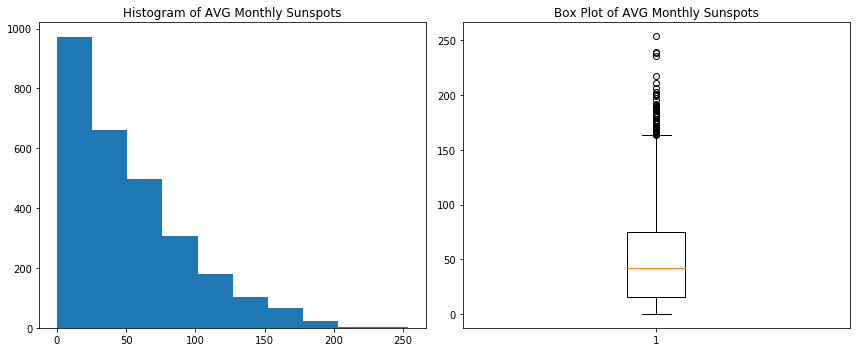

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(ss['Sunspots'], bins=10)
plt.title('Histogram of AVG Monthly Sunspots')
plt.subplot(1, 2, 2)
plt.boxplot(ss['Sunspots'])
plt.title('Box Plot of AVG Monthly Sunspots')
plt.tight_layout()
plt.show()

**Explore how well a simple linear model will predict future values. Will use a linear regression model with a few different options for the number of predictors and a random forest regression just to see how well they perform and then move on to ARIMA models.**  

In the cell below each columns will be the number of sunspots that occurred in the next month. We will try to predict the future months by building a linear model from previous months. We will start with a single month and add additional months to see how it affects model performance.

In [16]:
# Create a "constant" value for the number of columns of data to regress on
NCOLS = 100

In [17]:
sslr = ss.copy()
sslr = sslr.rename(columns={'Sunspots': 'm0'})
for r in range(1,NCOLS):
    column_name = 'm{}'.format(r)
    sslr[column_name] = sslr['m0'].shift(-r)
sslr = sslr.dropna()
sslr.head()

,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9,...,m90,m91,m92,m93,m94,m95,m96,m97,m98,m99
Month,,,,,,,,,,,,,,,,,,,,,
1749-01-01,58.0,62.6,70.0,55.7,85.0,83.5,94.8,66.3,75.9,75.5,...,3.6,6.4,11.8,14.3,17.0,9.4,14.1,21.2,26.2,30.0
1749-02-01,62.6,70.0,55.7,85.0,83.5,94.8,66.3,75.9,75.5,158.6,...,6.4,11.8,14.3,17.0,9.4,14.1,21.2,26.2,30.0,38.1
1749-03-01,70.0,55.7,85.0,83.5,94.8,66.3,75.9,75.5,158.6,85.2,...,11.8,14.3,17.0,9.4,14.1,21.2,26.2,30.0,38.1,12.8
1749-04-01,55.7,85.0,83.5,94.8,66.3,75.9,75.5,158.6,85.2,73.3,...,14.3,17.0,9.4,14.1,21.2,26.2,30.0,38.1,12.8,25.0
1749-05-01,85.0,83.5,94.8,66.3,75.9,75.5,158.6,85.2,73.3,75.9,...,17.0,9.4,14.1,21.2,26.2,30.0,38.1,12.8,25.0,51.3


In [18]:
# Perform a linear regression using 1 to NCOLS-1 independent variables
results = []
results_mins = []
results_maxs = []
test_results = []
CV = 3
for r in range(NCOLS-1):
    X = sslr.iloc[:,0:r+1]
    y = sslr.iloc[:, r+1:r+2]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    lr = LinearRegression()
    cv_results = cross_val_score(lr, X_train, y_train, cv=CV)
    results.append(sum(cv_results) / CV)
    results_mins.append(min(cv_results))
    results_maxs.append(max(cv_results))
    lr.fit(X_train, y_train)
    test_results.append(lr.score(X_test, y_test))


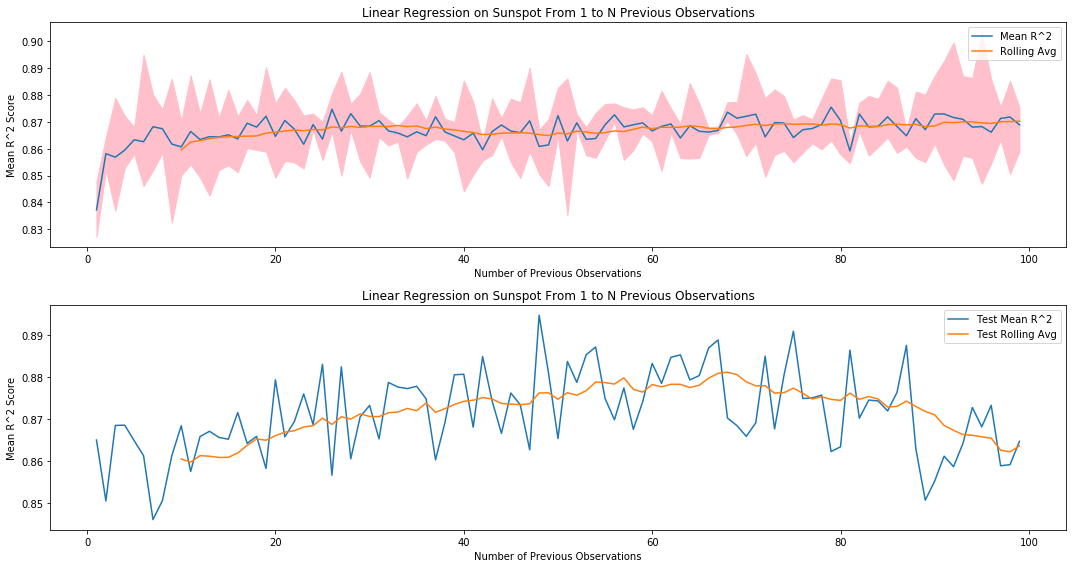

In [19]:

plt.figure(figsize=(15,8))
plt.subplot(2, 1, 1)
plt.plot(range(1, len(results)+1), results)
plt.plot(range(1, len(results)+1), np.zeros(len(results)) + pd.Series(results).rolling(10).mean())
plt.fill_between(range(1, len(results)+1), results_mins, results_maxs, color='pink')
plt.legend(['Mean R^2', 'Rolling Avg'])
plt.title('Linear Regression on Sunspot From 1 to N Previous Observations')
plt.ylabel('Mean R^2 Score')
plt.xlabel('Number of Previous Observations')

plt.subplot(2, 1, 2)
plt.plot(range(1, len(results)+1), test_results)
plt.plot(range(1, len(results)+1), np.zeros(len(results)) + pd.Series(test_results).rolling(10).mean())
plt.legend(['Test Mean R^2', 'Test Rolling Avg'])
plt.title('Linear Regression on Sunspot From 1 to N Previous Observations')
plt.ylabel('Mean R^2 Score')
plt.xlabel('Number of Previous Observations')
plt.tight_layout()
plt.show()

**It appeared that there was a really high $$R^2$$ value no matter how many previous observaions I looked at thus I wanted to test it agaist random numbers to make sure the $$R^2$$ wasn't just and artifact of of all the observations being in the same range roughly speaking. Below is an experiement with data generated with randint(). It shows that the $$R^2$$ value is zero or less with randonly generated numbers.**

In [20]:
fake = {x: [randint(50, 75) for y in range(sslr.shape[0])] for x in range(100)}

In [21]:
fake = pd.DataFrame(fake)
fake.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,69,73,50,58,71,65,72,56,59,70,...,70,50,53,65,54,70,71,63,61,69
1,56,72,74,59,51,57,58,62,50,54,...,61,70,50,50,54,63,50,51,64,58
2,53,68,60,52,69,64,52,64,51,59,...,61,58,75,63,60,75,52,75,53,53
3,59,56,55,75,51,65,52,50,75,61,...,75,69,63,59,59,50,73,72,59,52
4,65,72,63,72,60,51,52,66,60,74,...,54,63,52,51,65,56,67,58,65,51


In [22]:
print(sslr.shape, fake.shape)

(2721, 100) (2721, 100)


In [23]:
# Perform a linear regression using 1 to NCOLS-1 independent variables
results = []
results_mins = []
results_maxs = []
test_results = []
CV = 3
for r in range(NCOLS-1):
    X = fake.iloc[:,0:r+1]
    y = sslr.iloc[:, r+1:r+2]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    lr = LinearRegression()
    cv_results = cross_val_score(lr, X_train, y_train, cv=CV)
    results.append(sum(cv_results) / CV)
    results_mins.append(min(cv_results))
    results_maxs.append(max(cv_results))
    lr.fit(X_train, y_train)
    test_results.append(lr.score(X_test, y_test))


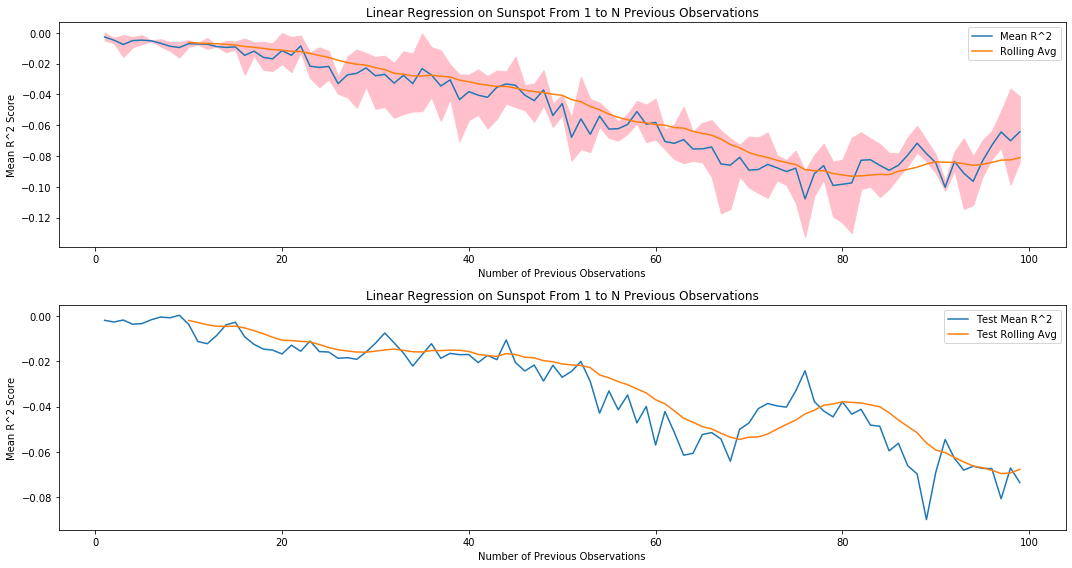

In [24]:

plt.figure(figsize=(15,8))
plt.subplot(2, 1, 1)
plt.plot(range(1, len(results)+1), results)
plt.plot(range(1, len(results)+1), np.zeros(len(results)) + pd.Series(results).rolling(10).mean())
plt.fill_between(range(1, len(results)+1), results_mins, results_maxs, color='pink')
plt.legend(['Mean R^2', 'Rolling Avg'])
plt.title('Linear Regression on Sunspot From 1 to N Previous Observations')
plt.ylabel('Mean R^2 Score')
plt.xlabel('Number of Previous Observations')

plt.subplot(2, 1, 2)
plt.plot(range(1, len(results)+1), test_results)
plt.plot(range(1, len(results)+1), np.zeros(len(results)) + pd.Series(test_results).rolling(10).mean())
plt.legend(['Test Mean R^2', 'Test Rolling Avg'])
plt.title('Linear Regression on Sunspot From 1 to N Previous Observations')
plt.ylabel('Mean R^2 Score')
plt.xlabel('Number of Previous Observations')
plt.tight_layout()
plt.show()

**Moving on to ARIMA Models to see how well they do with the data.**

**Stationarity**
1. Zero trend
2. Constant variance
3. Autocorrelation is constant

**Steps for each model**  
1. Time series covers the period January 1749 to December 1983
2. Moving window  
    a. train model on a 24 year or long period  
    b. In sample predicions for the last year of the period  
    c. Out of sample predictions for following year  
3. Growing Window:  
    a. train model on first 24 months of data and do same predictions as moving window  
    b. Grow window 24 years and repeat  
3. Find the RMSE of each prediction to measure effectiveness  
4. Use the following models:  
    a. Statsmodels SARIMAX  
    b. pmdarima auto_arima - allow it to find its own parameters and manually tune it  
    c. Facebook Prophet  
    d. ? - Possibly Pyflux for familiarity and to see how it performs against pmdarima  


In [25]:
max(ss['Sunspots'].index)

Timestamp('1983-12-01 00:00:00')

**There is a known approximately 11 year cycle in sunspot activity. There is definitely a cyclical patterns seen in the graph below. Will make an effort to deduce the actual length of the cycle.**

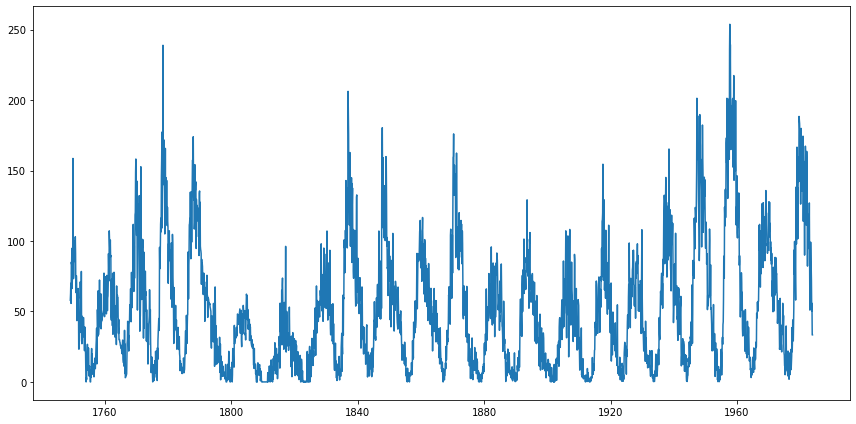

In [26]:
plt.figure(figsize=(12,6))
plt.plot(ss)
plt.tight_layout()
plt.show()

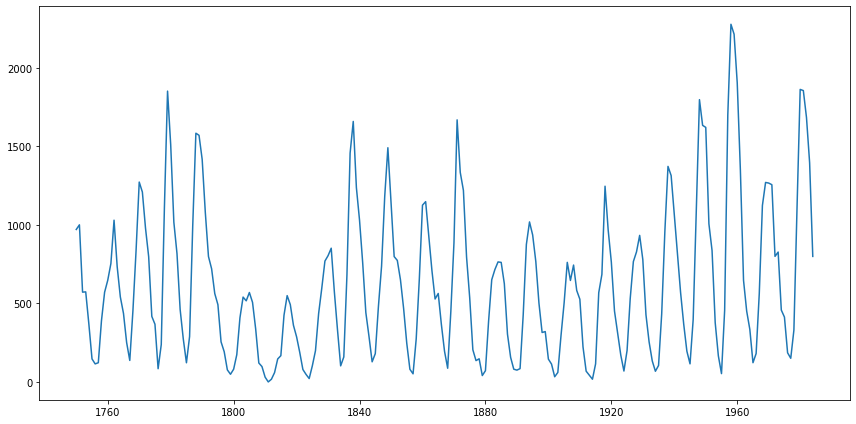

In [27]:
# Plot of annual sum of sunpots. It is a little smoother than the monthly mean and still shows the seasonality.
ss_annual = ss['Sunspots'].resample('1Y').sum()
plt.figure(figsize=(12,6))
plt.plot(ss_annual)
plt.tight_layout()
plt.show()

**In order to figure out the approximate length of the cycle we will remove trend by subtracting the rolling mean of the series. Then plot autocorrelations and see where they peak.**

In [28]:
ss_no_trend = (ss['Sunspots'] - ss['Sunspots'].rolling(48).mean()).dropna()
ss_no_trend_acf = pd.Series([ss_no_trend.autocorr(x) for x in range(1000)])

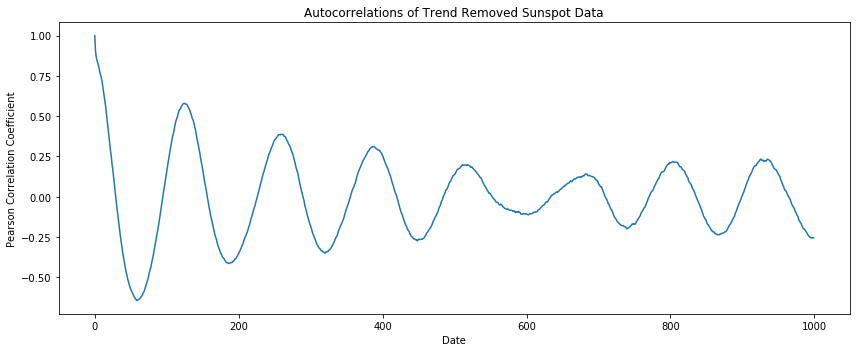

In [29]:
plt.figure(figsize=(12,5))
plt.plot(ss_no_trend_acf)
plt.title('Autocorrelations of Trend Removed Sunspot Data')
plt.xlabel('Date')
plt.ylabel('Pearson Correlation Coefficient')
plt.tight_layout()
plt.show()

In [30]:
def slope(series, slice_length=20):
    """Creates a pandas series object with the same index as input series.
    Returns the slope of the series based on the mean change of the series
    slice of length slice_length."""
    if slice_length % 2 == 0:
        offset = (slice_length // 2) - 1
    else:
        offset = slice_length // 2
    slope_series = pd.Series(index=series.index)
    for idx in series.index:
        slope_series[idx+offset] = series[idx:idx+slice_length].diff().mean()
    return slope_series

In [31]:
def slope2(series, slice_length=20):
    """Creates a pandas series object with the same index as input series.
    Returns the slope of the series based on the linear regression slope of the series
    slice of length slice_length."""
    x = np.arange(1, 10)
    if slice_length % 2 == 0:
        offset = (slice_length // 2) - 1
    else:
        offset = slice_length // 2
    slope_series = pd.Series(index=series.index)
    for idx in series.index:
        A = np.vstack([np.arange(1, slice_length), np.ones(len(x))]).T
        y = series[idx:idx+slice_length].values
        slope = round(lstsq(A, y)[0][0], 2)
        slope_series[idx+offset] = slope
    return slope_series


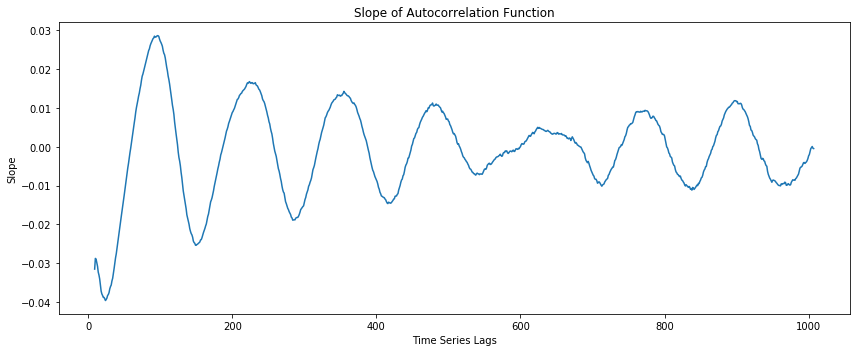

In [32]:
plt.figure(figsize=(12,5))
plt.plot(slope(ss_no_trend_acf))
plt.title('Slope of Autocorrelation Function')
plt.xlabel('Time Series Lags')
plt.ylabel('Slope')
plt.tight_layout()
plt.show()

In [33]:
# plt.figure(figsize=(12,5))
# plt.plot(slope2(ss_no_trend_acf))
# plt.tight_layout()
# plt.show()

In [34]:
def crosses_zero(series):
    """Returns a series of points where the slope goes from positive to negative."""
    points = []
    for idx in series.index[:-1]:
        if series[idx] > 0 and series[idx+1] < 0:
            points.append(idx+1)
    return pd.Series(points)

In [35]:
# Calculate the mean seasonal cycle based on slope of the acfs.
points = crosses_zero(slope(ss_no_trend_acf))
print(points)

0     125
1     258
2     388
3     516
4     683
5     803
6     931
7    1006
dtype: int64


In [36]:
# Calculate the mean difference for all but the last data point.
cycle_length = points[:-1].diff().mean()
print(cycle_length, cycle_length / 12)

134.33333333333334 11.194444444444445


**Based on the above calculation the mean cycle period is approximately 134 months which is 11.2 years. This does vary according to the literature on sun spot cycles.**

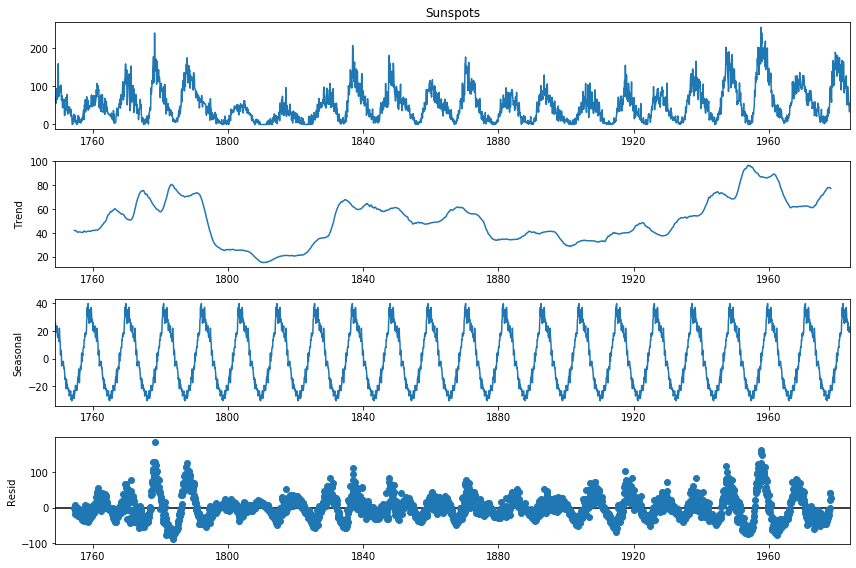

In [37]:
# Use statsmodels seasonal decompse with the calculated seasonal cycle
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib as mpl
with mpl.rc_context():
    mpl.rc("figure", figsize=(12,8))
    ss_decomp = seasonal_decompose(ss['Sunspots'], freq=134)
    ss_decomp.plot()
plt.show()

In [38]:
# Perform an augmented Dickey-Fuller test to see if the time series is stationary.
from statsmodels.tsa.stattools import adfuller
results = adfuller(ss['Sunspots'])
results

(-9.567667511913086,
 2.333452143866187e-16,
 27,
 2792,
 {'1%': -3.432694313168895,
  '5%': -2.862575752726396,
  '10%': -2.5673213632123297},
 23141.276837258665)

**The Dickey-Fuller test indicates that the sunspots time series is stationary so no differencing will be needed to make it stationary. It is seasonal so differencing will be done to remove seasonality and find order parameters p & q.**  
  
**UPDATE: While the series passed the augmented dickey fuller test initially, taking a first difference to remove trend resulted in a simpler set of model orders.**

Text(0.5, 1.0, 'Sunspots Time Series with Seasonality Removed')

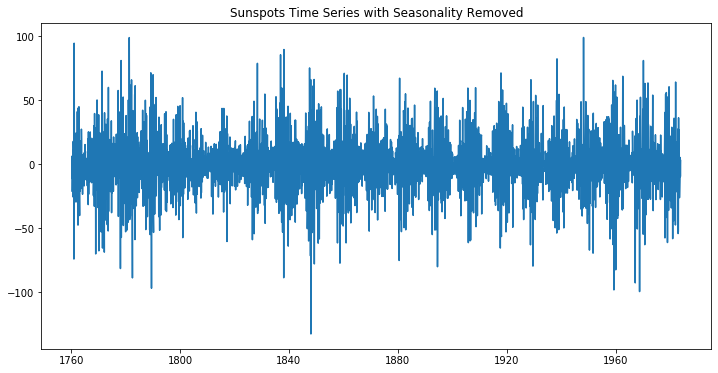

In [52]:
ss_no_season = ss['Sunspots'].diff().diff(134).dropna()
plt.figure(figsize=(12,6))
plt.plot(ss_no_season)
plt.title('Sunspots Time Series with Seasonality Removed')

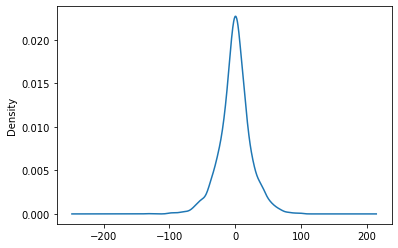

In [55]:
ss_no_season.plot.kde()

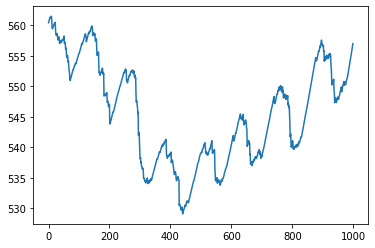

In [59]:
var = pd.Series([ss_no_season.shift(x).dropna().var() for x in range(1000)])
plt.plot(var)

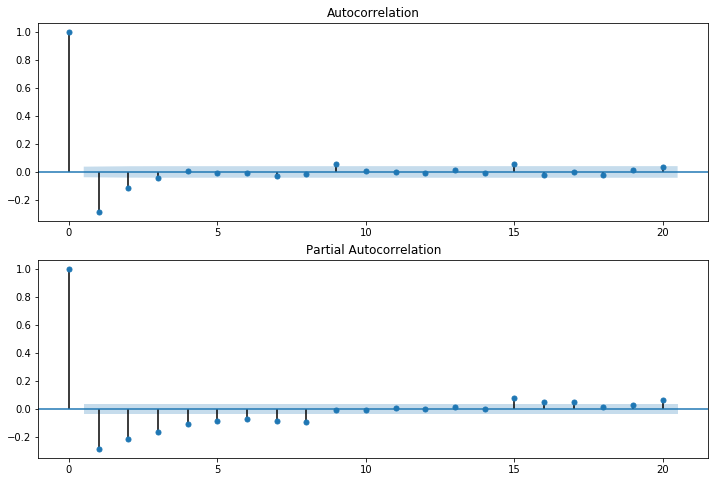

In [40]:
# Plot ACF and Partial ACF for a detrended and deseasoned time series.
with mpl.rc_context():
    mpl.rc("figure", figsize=(12,8))
    fig, (ax1, ax2) = plt.subplots(2, 1)
    plot_acf(ss_no_season, lags=20, ax=ax1)
    plot_pacf(ss_no_season, lags=20, ax=ax2)
plt.show()

**It is not obvious what the model orders p & q should be from the acf and pacf. We will fit multiple models and find the models with the lowest AIC and BIC.**

In [41]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_results = {'lags': [], 'p': [], 'q': [], 'AIC': [], 'BIC': []}
for lags in range(133, 135):
    lagged_sunspots = ss['Sunspots'].diff().diff(lags).dropna()
    for p in range(7):
        for q in range(4):
            try:
                model = ARIMA(lagged_sunspots, order=(p, 0, q), freq='MS', dates=lagged_sunspots.index)
                results = model.fit()
                model_results['lags'].append(lags)
                model_results['p'].append(p)
                model_results['q'].append(q)
                model_results['AIC'].append(results.aic)
                model_results['BIC'].append(results.bic)
            except:
                print('Non-stationary Result at {}, {}, {}'.format(lags, p, q))
results_df = pd.DataFrame(model_results)
results_df.sample(10)

,lags,p,q,AIC,BIC
36,134,2,0,24269.556966,24293.138710
2,133,0,2,24237.479116,24261.062349
49,134,5,1,24121.479733,24168.643221
33,134,1,1,24118.664060,24142.245804
51,134,5,3,24085.925054,24144.879414
46,134,4,2,24088.307729,24135.471217
34,134,1,2,24118.840313,24148.317493
37,134,2,1,24118.595172,24148.072352
4,133,1,0,24483.023143,24500.710568
43,134,3,3,24083.094915,24130.258403


In [42]:
results_df.sort_values('AIC', ascending=True).head()

,lags,p,q,AIC,BIC
43,134,3,3,24083.094915,24130.258403
51,134,5,3,24085.925054,24144.879414
47,134,4,3,24086.589210,24139.648134
46,134,4,2,24088.307729,24135.471217
50,134,5,2,24088.853734,24141.912658


In [43]:
# Best model based on zero differencing is lags=134, p=3, q=3

[134 268 402 536]


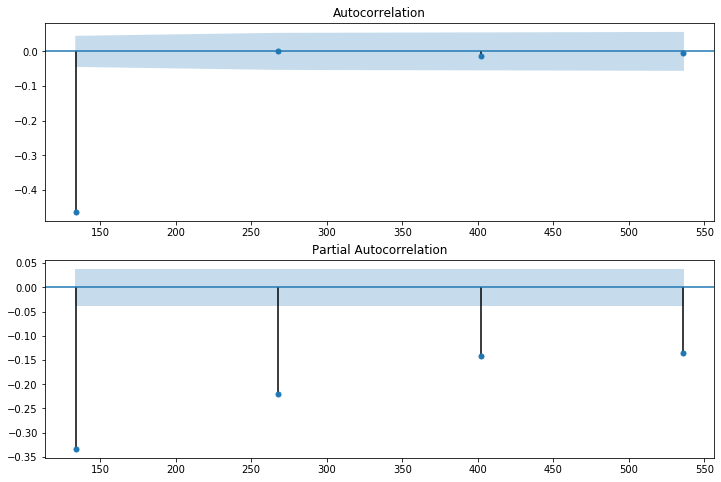

In [44]:
# Plot ACF and Partial ACF for a detrended and deseasoned time series.
lags = np.arange(1,5) * 134
print(lags)
ss_ts = ss['Sunspots'].diff().diff(134).dropna()
with mpl.rc_context():
    mpl.rc("figure", figsize=(12,8))
    fig, (ax1, ax2) = plt.subplots(2, 1)
    plot_acf(ss_ts, lags=lags, ax=ax1)
    plot_pacf(ss_ts, lags=lags, ax=ax2)
plt.show()

**Based on the ACF and PACF of the seasonal lags this appears to be a P=0, Q=1 seasonal model.**

In [45]:
sunspots = SARIMAX(ss['Sunspots'].loc['1749':'1981'], order=(3,1,3), seasonal_order=(0,0,1,134), trend='c')
model = sunspots.fit()

In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                              Sunspots   No. Observations:                 2796
Model:             SARIMAX(3, 1, 3)x(0, 0, [1], 134)   Log Likelihood              -11659.266
Date:                               Thu, 09 Apr 2020   AIC                          23336.533
Time:                                       17:02:07   BIC                          23389.953
Sample:                                   01-01-1749   HQIC                         23355.817
                                        - 12-01-1981                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0904      0.392      0.231      0.818      -0.678       0.859
ar.L1         -1.1395      0.040    -28.451      0.000      -1.218      -1.061
ar.L2         -0.6448      0.046    -14.117      0.000      -0.734      -0.555
ar.L3          0.1755      0.034      5.224      0.000       0.110       0.241
ma.L1          0.7289      0.036     20.475      0.000       0.659       0.799
ma.L2          0.0646      0.039      1.667      0.095      -0.011       0.141
ma.L3         -0.5931      0.033    -18.134      0.000      -0.657      -0.529
ma.S.L134      0.0505      0.018      2.825      0.005       0.015       0.085
sigma2       246.6582      4.205     58.658      0.000     238.417     254.900
===================================================================================
Ljung-Box (Q):                      139.86   Jarque-Bera (JB):              1432.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**SARIMA Model trained on 50 years of sunspot data with order (3,1,3) and seasonal order (0,0,1,134)**

(100.44696171535315, 104.30777351412375)


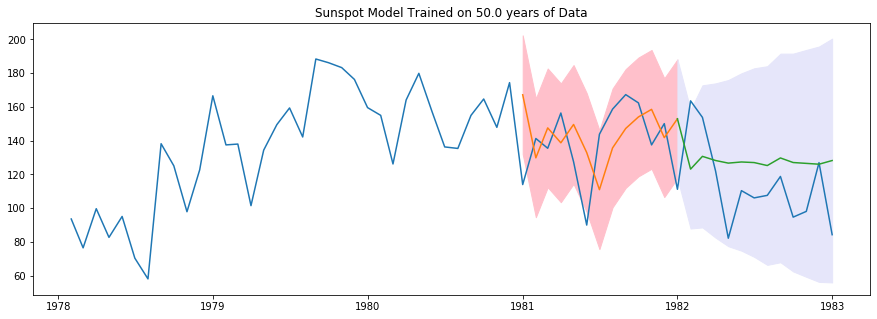

In [25]:
(ms50, ms50_model) = moving_sarima(ss, start=datetime(year=1982-50, month=1, day=1), window_size=relativedelta(years=50), 
                   n_in_sample_predictions=12, n_out_of_sample_predictions=12, order=(3,1,3), 
                   seasonal_order=(0,0,1,134), trend='c')
print(prediction_rmse_summary(ms50))
plot_window(ms50)

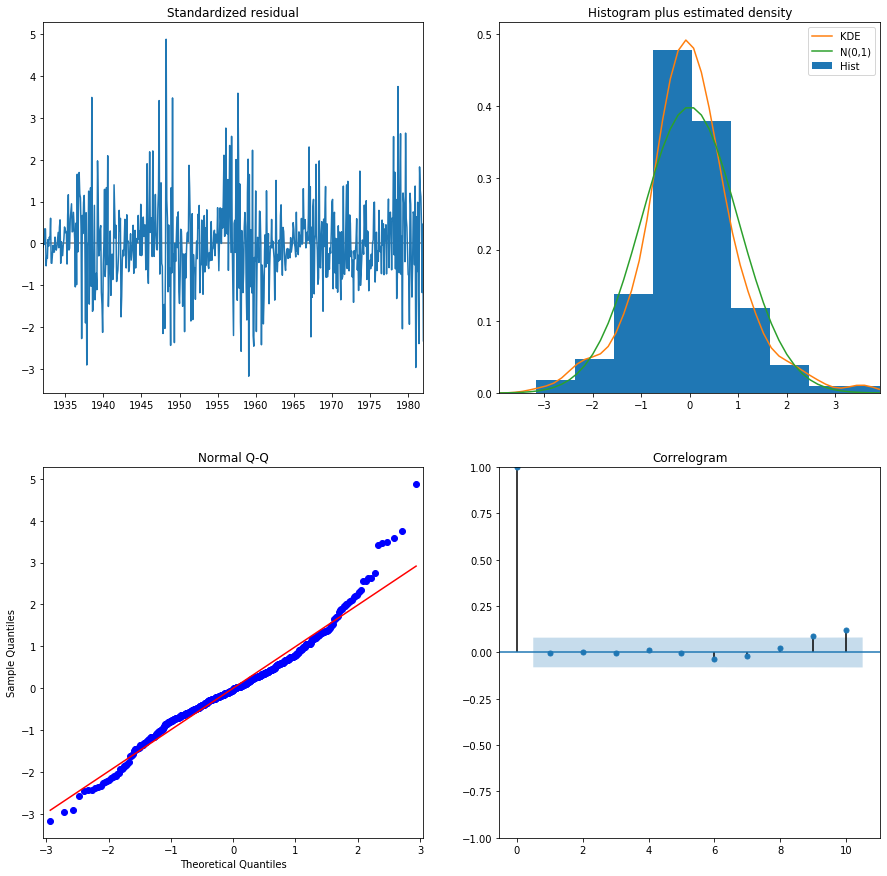

In [32]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(15,15))
    ms50_model.plot_diagnostics()
plt.show()

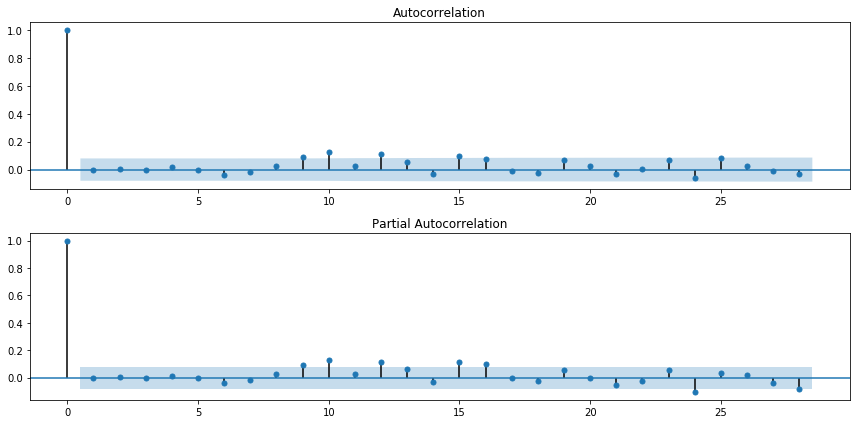

In [48]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12,6))
    fig, (ax1, ax2) = plt.subplots(2,1)
    plot_acf(ms50_model.resid, ax=ax1)
    plot_pacf(ms50_model.resid, ax=ax2)
plt.tight_layout() 
plt.show()

In [36]:
type(ms50_model.resid)

pandas.core.series.Series

In [33]:
print(ms50_model.summary())

                                       SARIMAX Results                                       
Dep. Variable:                              Sunspots   No. Observations:                  601
Model:             SARIMAX(3, 1, 3)x(0, 0, [1], 134)   Log Likelihood               -2581.093
Date:                               Thu, 09 Apr 2020   AIC                           5180.186
Time:                                       19:18:06   BIC                           5219.758
Sample:                                   01-01-1932   HQIC                          5195.591
                                        - 01-01-1982                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2993      0.758      0.395      0.693      -1.187       1.785
ar.L1      

**SARIMA Model trained on 100 years of sunspot data with order (3,1,3) and seasonal order (0,0,1,134)**

(97.78604776938705, 106.64281309568152)


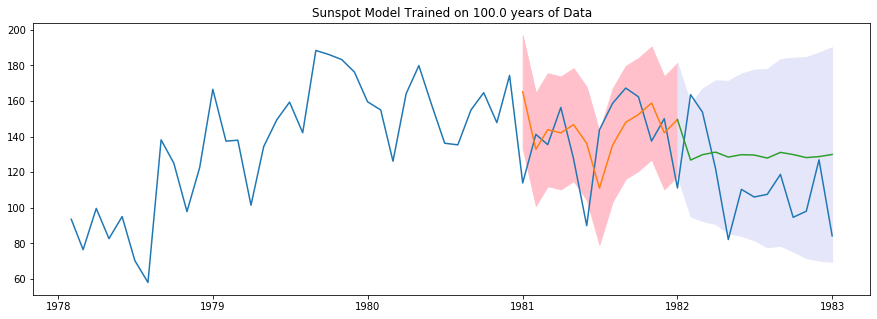

In [30]:
(ms100, ms100_model) = moving_sarima(ss, start=datetime(year=1982-100, month=1, day=1), window_size=relativedelta(years=100), 
                   n_in_sample_predictions=12, n_out_of_sample_predictions=12, order=(3,1,3), 
                   seasonal_order=(0,0,1,134), trend='c')
print(prediction_rmse_summary(ms100))
plot_window(ms100)

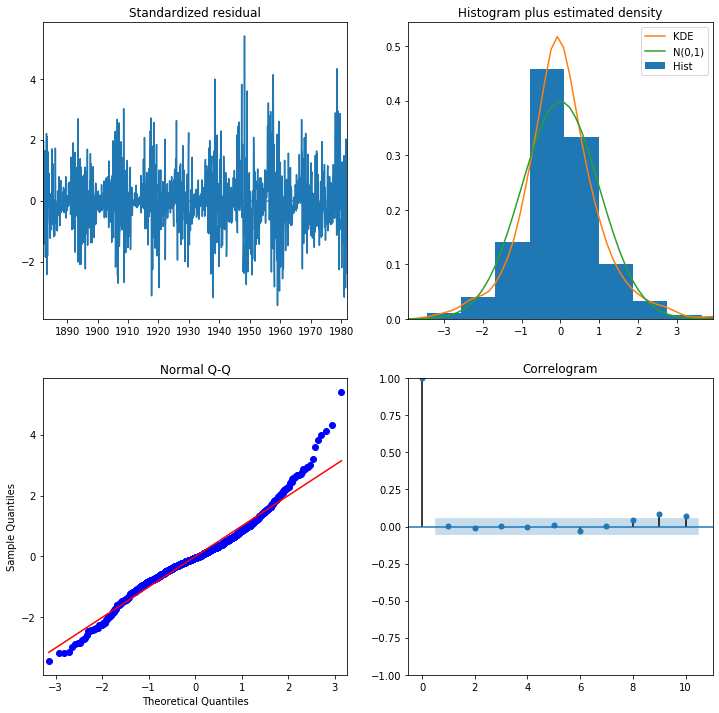

In [31]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(15,15))
    ms100_model.plot_diagnostics()
plt.show()

**SARIMA Model trained on 150 years of sunspot data with order (3,1,3) and seasonal order (0,0,1,134)**

(96.35127503732846, 104.22988314006594)


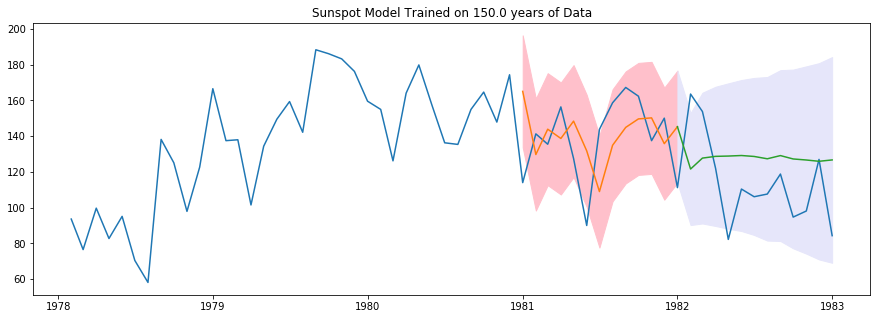

In [22]:
ms150 = moving_sarima(ss, start=datetime(year=1982-150, month=1, day=1), window_size=relativedelta(years=150), 
                   n_in_sample_predictions=12, n_out_of_sample_predictions=12, order=(3,1,3), 
                   seasonal_order=(0,0,1,134), trend='c')
print(prediction_rmse_summary(ms150))
plot_window(ms150)

**SARIMA Model trained on 200 years of sunspot data with order (3,1,3) and seasonal order (0,0,1,134)**

(95.46337194243954, 105.52267943912963)


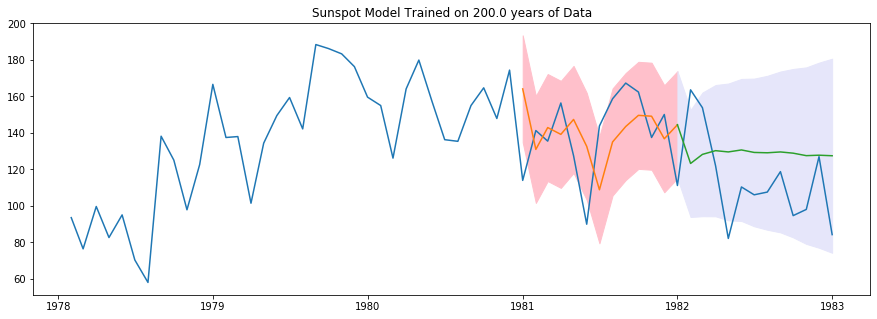

In [23]:
ms200 = moving_sarima(ss, start=datetime(year=1982-200, month=1, day=1), window_size=relativedelta(years=200), 
                   n_in_sample_predictions=12, n_out_of_sample_predictions=12, order=(3,1,3), 
                   seasonal_order=(0,0,1,134), trend='c')
print(prediction_rmse_summary(ms200))
plot_window(ms200)

In [ ]:
---

**Pmdarima -- Auto SARIMA that automatically fits the AR, MA terms.**

In [ ]:
am50 = pm.auto_arima(ss)
am50.fit()

In [ ]:
def fit_predict_auto_arima(data, start, window_size, n_in_sample_predictions=0, 
                           n_out_of_sample_predictions=0, order=None, 
                           seasonal_order=None, trend=None):
    """Trains a statsmodels auto_arima model on a time series using a moving window.
    The model will perform n_in_sample_predictions on the tail of the data
    and n_out_of_sample_predictions at the end of the window.
    
    The data must be at least window_size + n_out_of_sample_predictions elements
    long if n_out_of_sample_predictions > 0.
    
    Returns a Pandas DataFrame object with original data, in sample predictions and
    out of sample predictions and indexed with the original data.index"""
    
    dynamic_window = relativedelta(months=n_out_of_sample_predictions)
    in_sample_window = relativedelta(months=n_in_sample_predictions)
    
    return_data = data.loc[start:start+window_size+dynamic_window].copy()
    train_data = data.loc[start:start+window_size].copy()
    
    aa = pm.auto_arima(data.loc[start:start+window_size])
    model = aa.fit()
    
    in_sample_predictions = model.get_prediction(start=start+window_size-in_sample_window)
    in_conf_int = in_sample_predictions.conf_int()
    in_conf_int.columns = ['in_sample_low_conf', 'in_sample_high_conf']
    
    out_sample_pred = model.get_prediction(start=start+window_size, end=start+window_size+dynamic_window)
    out_conf_int = out_sample_pred.conf_int()
    out_conf_int.columns = ['out_sample_low_conf', 'out_sample_high_conf']
    
    return_data = return_data.merge(in_sample_predictions.predicted_mean.rename('in_sample_pred'), how='left', left_index=True, right_index=True)
    return_data = return_data.merge(in_conf_int, how='left', left_index=True, right_index=True)
    
    return_data = return_data.merge(out_sample_pred.predicted_mean.rename('out_sample_pred'), how='left', left_index=True, right_index=True)
    return_data = return_data.merge(out_conf_int, how='left', left_index=True, right_index=True)
    
    return return_data
    
    

In [ ]:
plt.plot(ss['Sunspots'].diff(1))

**TODO**  
1. Rework dynamic predictions  
2. Add Facebook Prophet models

In [ ]:
from fbprophet import Prophet as Prophet

In [ ]:
ss_prophet = ss.loc['1975':'1981'].reset_index()
ss_prophet.columns = ['ds', 'y']
ss_prophet.head()

In [ ]:
prophet_model = Prophet()
prophet_model.fit(ss_prophet)
future = prophet_model.make_future_dataframe(periods=60)
prophet_forecast = prophet_model.predict(future)
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

In [ ]:
prophet_model.plot(prophet_forecast, xlabel='Date', ylabel='Share Price ($)')
plt.title('Facebook Prophet Predictions')
# display graph
plt.legend()
plt.show()